In [39]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [40]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [41]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, select, func, inspect

In [42]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [43]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [44]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [45]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [46]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Precipitation Analysis

In [47]:
inspector = inspect(engine)

In [48]:
inspector.get_table_names() 

['measurement', 'station']

In [49]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [50]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
print(f"The most recent date in the data set is: {most_recent_date}")

The most recent date in the data set is: 2017-08-23


In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date = pd.to_datetime(most_recent_date).date() # truncate time of day
# Calculate the date one year from the last date in data set.
one_year_ago_date = most_recent_date - pd.DateOffset(years=1)
one_year_ago_date = one_year_ago_date.date() # truncate time of day
print(one_year_ago_date)



2016-08-23


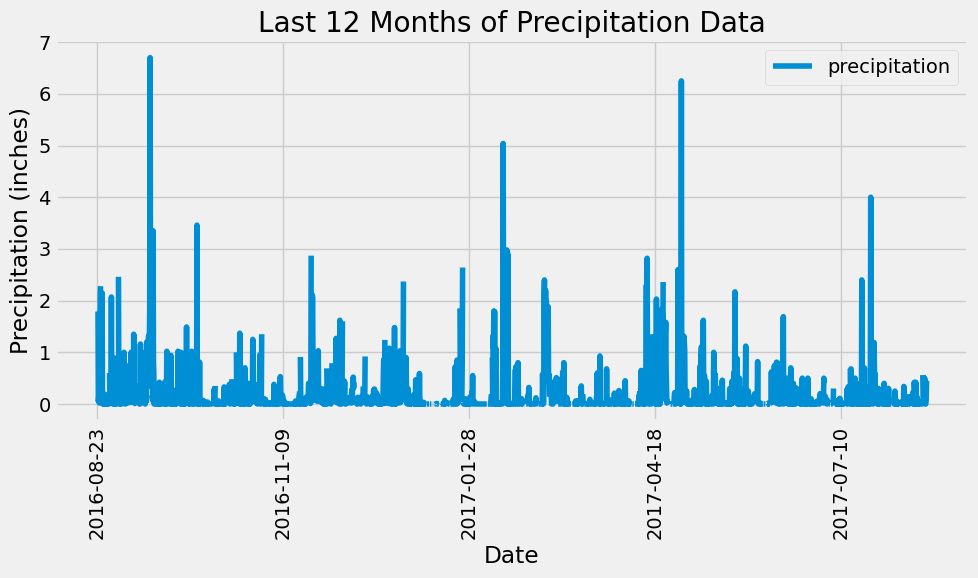

In [52]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)


# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10, 6))
df.plot(ax=ax, rot=90)
ax.set_title("Last 12 Months of Precipitation Data")
ax.set_ylabel("Precipitation (inches)")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

In [53]:
# Use Pandas to calculate the summary statistics for the precipitation data
climate_df = df.describe()
climate_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number of stations in the dataset
total_station = session.query(station).distinct().count()
print(total_station)

9


In [55]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [63]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station).label('count')) \
                         .group_by(measurement.station) \
                         .order_by(func.count(measurement.station).desc()) \
                         .all()

for station in active_stations:
    print(f"{station.station}: {station.count}")



USC00519281: 2772
USC00519397: 2724
USC00513117: 2709
USC00519523: 2669
USC00516128: 2612
USC00514830: 2202
USC00511918: 1979
USC00517948: 1372
USC00518838: 511


In [65]:
# First, get the most active station
most_active_station = session.query(measurement.station, func.count(measurement.station).label('count')) \
                         .group_by(measurement.station) \
                         .order_by(func.count(measurement.station).desc()) \
                         .first()

# Then, calculate the lowest, highest, and average temperature for that station
results = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)) \
                  .filter(measurement.station == most_active_station.station) \
                  .all()

# Finally, print out the results
print(f"Lowest Temperature: {results[0][0]}")
print(f"Highest Temperature: {results[0][1]}")
print(f"Average Temperature: {results[0][2]}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


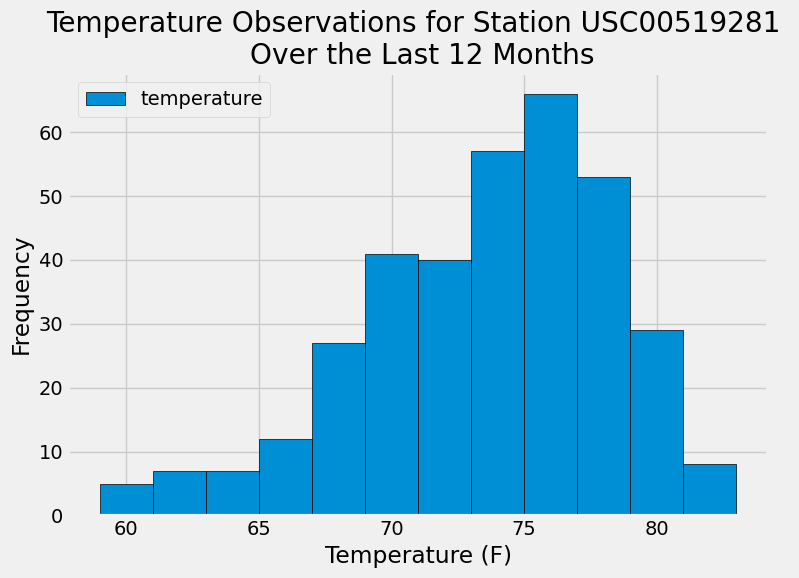

In [66]:
# Get the most active station
most_active_station = session.query(measurement.station, func.count(measurement.station).label('count')) \
                         .group_by(measurement.station) \
                         .order_by(func.count(measurement.station).desc()) \
                         .first()

# Query the last 12 months of temperature observation data for the most active station
results = session.query(measurement.tobs) \
                  .filter(measurement.station == most_active_station.station) \
                  .filter(measurement.date >= one_year_ago_date) \
                  .all()

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(results, columns=['temperature'])

# Plot the temperature histogram
fig, ax = plt.subplots(figsize=(8, 6))
df.plot.hist(bins=12, ax=ax, edgecolor='black')
ax.set_title(f"Temperature Observations for Station {most_active_station.station} \n Over the Last 12 Months")
ax.set_xlabel("Temperature (F)")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close Session

In [67]:
# Close Session
session.close()